## Concatenating multiple surf sessions together to perform ML analysis:

In [333]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [334]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [335]:
ride_ids_array = ['15629', '15669', '15692', '15686', '15962', '15963', '15971', '15972']


#ride_ids = ['15629']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!
# 15962 - Rachelle's 1st Ride Sesh filmed with VIRB (Nov. 11) //5th labelled footage!
# 15963 - Jasmine's 5th Ride Sesh filmed with VIRB (Nov. 11) //6th labelled footage!
# 15971 - Mexico Sesh filmed with VIRB (Nov. 11) //7th labelled footage!
# 15972 - Jasmine's 7th Ride Sesh filmed with VIRB (Nov. 11) //8th labelled footage!


## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [336]:
#%% Fin ID scraper

def create_ride_from_id():
    # Input fin ID, get all ride IDs
    # base URL to which we'll append given fin IDs
    fin_url_base = 'http://surf.smartfin.org/fin/'

    # Look for the following text in the HTML contents in fcn below
    str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
    str_id_date = 'var date = \'' # backslash allows us to look for single quote

    #%% Ride ID scraper
    # Input ride ID, get ocean and motion CSVs
    # Base URL to which we'll append given ride IDs
    ride_url_base = 'https://surf.smartfin.org/ride/'

    # Look for the following text in the HTML contents in fcn below
    str_id_csv = 'img id="temperatureChart" class="chart" src="' 

    def get_csv_from_ride_id(rid):
        # Build URL for each individual ride
        ride_url = ride_url_base+str(rid)
        print(ride_url)

        # Get contents of ride_url
        html_contents = requests.get(ride_url).text

        # Find CSV identifier 
        loc_csv_id = html_contents.find(str_id_csv)

        # Different based on whether user logged in with FB or Google
        offset_googleOAuth = [46, 114]
        offset_facebkOAuth = [46, 112]
        if html_contents[loc_csv_id+59] == 'f': # Facebook login
            off0 = offset_facebkOAuth[0]
            off1 = offset_facebkOAuth[1]
        else: # Google login
            off0 = offset_googleOAuth[0]
            off1 = offset_googleOAuth[1]

        csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]

    #    print(csv_id_longstr)

        # Stitch together full URL for CSV
        if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything

            ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
            motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'

            print(ocean_csv_url)
            # Go to ocean_csv_url and grab contents (theoretically, a CSV)
            ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
            elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
            ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')

            motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])

            # Reindex on timestamp if there are at least a few rows
            if len(ocean_df_small) > 1:
                ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
                motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)

                #print(ocean_df_small)
                #print(motion_df_small)

                #May need to change this sampling interval:
                sample_interval = '33ms'


                ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
                motion_df_small_resample = motion_df_small.resample(sample_interval).mean()

                # No need to save many extra rows with no fix
                motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]

                return ocean_df_small_resample, motion_df_small_resample

        else:
            ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
            motion_df_small_resample = pd.DataFrame() 
            return ocean_df_small_resample, motion_df_small_resample

    appended_ocean_list = [] # list of DataFrames from original CSVs
    appended_motion_list = []
    appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

    ## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
    ## (Here, ride IDS are either ocean or motion dataframes)
    count_good_fins = 0

    # Loop over ride_ids and find CSVs
    for rid in ride_ids:
        try:
            new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
            #print(len(new_ocean_df))
            #print(len(new_motion_df))
            if not new_ocean_df.empty: # Calibration rides, for example
                # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
                appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
                appended_ocean_list.append(new_ocean_df)
                appended_motion_list.append(new_motion_df)
                print("Ride data has been uploaded.")
                #print("Ride: ", rid, "data has been uploaded.")
                count_good_fins += 1

        except: 
            print("Ride threw an exception!")
            #print("Ride ", rid, "threw an exception!")    

    #%% Build the "Master" DataFrame

    # appended_ocean_df.summary()
    df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
    ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
    motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])



    #print(motion_df)
    
    
    ##Drop the NA values from the dataframe: 
    motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])
    motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
    #print(motion_df_dropped)
    
    #Create an elapsed_timedelta field:
    motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
    motion_df_dropped.head(10)
    
    return motion_df_dropped
    

## Create dictionary to store {ride_id, dataframe}:

In [337]:
#ride_ids_array = ['15629', '15669', '15692', '15686', '15962', '15963', '15971', '15972']

dataframe_collection = {} 

for ride in ride_ids_array:
    ride_ids = [ride]
    dataframe_collection.update({ride:create_ride_from_id()})
    

https://surf.smartfin.org/ride/15629
https://surf.smartfin.org/media/201810/google_105349665704999793400_0006667E229D_181031013846_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15669
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181107203025_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15686
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181111203352_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15962
https://surf.smartfin.org/media/201902/google_105349665704999793400_0006667E229D_190208171724_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15963
https://surf.smartfin.org/media/201902/google_105349665704999793400_0006667E229D_190222184248_Ocean.CSV
Ride data

## Print to check dataframe collection:

In [338]:
print(dataframe_collection['15629'].head(10))

                                       Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                   
15629   2018-10-31 19:33:01.839  11992061.0    -6.0   540.0    47.0   -24.0   
        2018-10-31 19:33:02.103  11992311.0     4.0   514.0    93.0    10.0   
        2018-10-31 19:33:02.334  11992561.0    14.0   532.0   126.0    40.0   
        2018-10-31 19:33:02.598  11992813.0    13.0   528.0   133.0   -72.0   
        2018-10-31 19:33:02.829  11993063.0    23.0   481.0   121.0   -30.0   
        2018-10-31 19:33:03.093  11993313.0    24.0   452.0   105.0    74.0   
        2018-10-31 19:33:03.357  11993564.0    10.0   467.0    39.0    33.0   
        2018-10-31 19:33:03.588  11993815.0    -5.0   490.0    60.0  -151.0   
        2018-10-31 19:33:03.852  11994065.0    16.0   475.0    94.0  -117.0   
        2018-10-31 19:33:04.116  11994316.0   -17.0   461.0    38.0   -34.0   

                                 IMU G2  IMU G3  IM

In [339]:
print(dataframe_collection['15972'].head(10))

                                        Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                    
15972   2019-02-25 01:31:59.613  400259893.0   101.0   562.0    71.0   241.0   
        2019-02-25 01:31:59.877  400260143.0   -44.0   311.0   104.0    89.0   
        2019-02-25 01:32:00.108  400260394.0   -32.0   606.0    80.0  -132.0   
        2019-02-25 01:32:00.372  400260644.0     8.0   537.0   102.0  -112.0   
        2019-02-25 01:32:00.636  400260896.0   -70.0   406.0    99.0   -17.0   
        2019-02-25 01:32:00.867  400261145.0   -69.0   469.0    75.0   175.0   
        2019-02-25 01:32:01.131  400261395.0   -67.0   475.0    82.0   111.0   
        2019-02-25 01:32:01.362  400261646.0   -63.0   495.0    70.0   -13.0   
        2019-02-25 01:32:01.626  400261896.0   -60.0   499.0    84.0   -12.0   
        2019-02-25 01:32:01.890  400262147.0   -59.0   484.0    78.0   -46.0   

                                 IMU G2

In [340]:
list(dataframe_collection['15972'])

['Time',
 'IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'TimeDelta']

## Convert the IMU data into real value units:  

In [341]:
def convert_real(input_df):

    df_converted = input_df.copy()

    #Faster way to iterate over columns: 
    df_converted['IMU A1'] = input_df['IMU A1'].apply(lambda x: x*-0.019141) #forwards/backwards
    #Need to find a better way to subtract gravity: 
    df_converted['IMU A2'] = input_df['IMU A2'].apply(lambda x: x*0.019141-9.81)  #upside down/right side up
    df_converted['IMU A3'] = input_df['IMU A3'].apply(lambda x: x*0.019141)  #sideways: negative = left, positive = right

    df_converted['IMU G1'] = input_df['IMU G1'].apply(lambda x: x/8.2)     #roll
    df_converted['IMU G2'] = input_df['IMU G2'].apply(lambda x: x/8.2)     #yaw
    df_converted['IMU G3'] = input_df['IMU G3'].apply(lambda x: x/8.2)     #pitch (flipping forwards/backwards)

    return df_converted

In [342]:
real_dataframe_collection = {}

for ride in ride_ids_array:
    real_df = convert_real(dataframe_collection[ride])
    real_dataframe_collection.update({ride:real_df})
    
real_df.head(10)

Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                  
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241  0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204 -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512  1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128  0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870 -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729 -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447 -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883 -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460 -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319 -0.545756  1.492998   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15972   2019-02-25 01:31:59.613  29.390244  15.121951  -2.560976  -107.0   
        2019-02-25 01:31:59.877  10.853659   6.463415 -33.536585   -85.0   
        2019-02-25 01:32:00.108 -16.097561   2.560976   3.414634   -68.0   
        2019-02-25 01:32:00.372 -13.658537   3.902439   3.048780   -77.0   
        2019-02-25 01:32:00.636  -2.073171   6.585366   0.365854   -81.0   
        2019-02-25 01:32:00.867  21.341463  10.121951   1.097561   -74.0   
        2019-02-25 01:32:01.131  13.536585   8.170732   2.317073   -86.0   
        2019-02-25 01:32:01.362  -1.585366   5.487805   2.439024   -88.0   
        2019-02-25 01:32:01.626  -1.463415   4.390244   0.121951   -91.0   
        2019-02-25 01:32:01.890  -5.609756   2.926829   1.341463   -85.0   

                                 IMU M2  IMU M3  TimeDelta  
ride_id UTC                                                 
15972   2019-02-25 01:31:59.613  -169.0   181.0        0.0  
        2019-02-25 01:31:59.877  -149.0   201.0      250.0  
        2019-02-25 01:32:00.108  -152.0   194.0      501.0  
        2019-02-25 01:32:00.372  -167.0   175.0      751.0  
        2019-02-25 01:32:00.636  -171.0   167.0     1003.0  
        2019-02-25 01:32:00.867  -170.0   168.0     1252.0  
        2019-02-25 01:32:01.131  -166.0   202.0     1502.0  
        2019-02-25 01:32:01.362  -162.0   196.0     1753.0  
        2019-02-25 01:32:01.626  -159.0   193.0     2003.0  
        2019-02-25 01:32:01.890  -163.0   193.0     2254.0

## Add input features (gyro, velocity windowing and BW filtering):

### Adding velocity windowing code (average windowing of recent instantaneous velocities): 

In [343]:
#Velocity windowing code: 

def velocity_window(input_dataframe):

    t = [float(input_dataframe['Time'][i]) for i in range(len(input_dataframe['Time']))]
    a1,a2,a3 = np.array(input_dataframe['IMU A1']),np.array(input_dataframe['IMU A2']),np.array(input_dataframe['IMU A3'])
    
    #a2 = a2-9.81; #need to actually calculate acceleration in correct vector
    a2 = a2-10
    
    v1 = np.zeros((len(input_dataframe),1))
    v2 = np.zeros((len(input_dataframe),1))
    v3 = np.zeros((len(input_dataframe),1))
    
    delta_t = 0.250; # TODO: calculate real deltas using the UTC time

    # Use magnitude as feature?
    # stats stuff in windows (means, medians, max/min)
    # fft?
    # velocity towards shore

    #Need to reset velocity to 0 when in small range to avoid drift
    mag = 0
    for i in range(len(input_dataframe)):
        # delta_t = ?   
        if i < 1:
            v1[i] = a1[i]*delta_t/2
            v2[i] = a2[i]*delta_t/2
            v3[i] = a3[i]*delta_t/2
            
        elif (-mag < v1[i] < mag) or (-mag < v2[i] < mag) or (-mag < v3[i] < mag):
            if (-mag < v1[i] < mag):
                v1[i] = 0
            if (-mag < v2[i] < mag):
                v2[i] = 0
            if (-mag < v3[i] < mag):
                v3[i] = 0
        else:
            v1[i] = v1[i] + (a1[i-2] + a1[i-1] + a1[i])*delta_t/3
            v2[i] = v2[i] + (a2[i-2] + a2[i-1] + a2[i])*delta_t/3  
            v3[i] = v3[i] + (a3[i-2] + a3[i-1] + a3[i])*delta_t/3
    
    
    #Creating dataframe columns from arrays:
    #v1_df = pd.DataFrame(v1,columns=['IMU V1'])
    #v2_df = pd.DataFrame(v2,columns=['IMU V2'])
    #v3_df = pd.DataFrame(v3,columns=['IMU V3'])


    #Input velocity into dataframes: 
    new_input_dataframe = input_dataframe
    new_input_dataframe['IMU V1'] = v1
    new_input_dataframe['IMU V2'] = v2
    new_input_dataframe['IMU V3'] = v3
    
    return new_input_dataframe


In [344]:
#Update a new dataframe collection with velocity added as an input feature:
v_dataframe_collection = {}

for ride in ride_ids_array:
    velocity_added_df = velocity_window(real_dataframe_collection[ride])
    v_dataframe_collection.update({ride:velocity_added_df})
    
velocity_added_df.head(100)

Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                   
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241   0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204  -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512   1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128   0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870  -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729  -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447  -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883  -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460  -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319  -0.545756  1.492998   
        2019-02-25 01:32:02.121  400262397.0  1.167601   0.105038  1.339870   
        2019-02-25 01:32:02.385  400262649.0  1.091037  -0.316064  1.760972   
        2019-02-25 01:32:02.649  400262899.0  1.014473  -0.852012  1.894959   
        2019-02-25 01:32:02.880  400263149.0  1.071896  -0.450051  1.760972   
        2019-02-25 01:32:03.144  400263400.0  1.091037  -0.622320  1.703549   
        2019-02-25 01:32:03.408  400263651.0  1.052755  -0.564897  1.473857   
        2019-02-25 01:32:03.639  400263901.0  1.033614   0.698409  1.588703   
        2019-02-25 01:32:03.903  400264152.0  0.995332  -1.024281  1.894959   
        2019-02-25 01:32:04.167  400264402.0  0.957050  -1.139127  1.607844   
        2019-02-25 01:32:04.398  400264646.0  1.033614   0.277307  1.512139   
        2019-02-25 01:32:04.662  400264896.0  1.033614   0.143320  1.607844   
        2019-02-25 01:32:04.893  400265147.0  1.014473  -0.698884  1.416434   
        2019-02-25 01:32:05.157  400265397.0  1.033614  -0.220359  1.626985   
        2019-02-25 01:32:05.421  400265650.0  0.995332  -0.201218  1.626985   
        2019-02-25 01:32:05.652  400265900.0  0.976191  -0.756307  1.397293   
        2019-02-25 01:32:05.916  400266151.0  0.976191  -1.043422  1.894959   
        2019-02-25 01:32:06.180  400266402.0  1.071896   0.047615  1.588703   
        2019-02-25 01:32:06.411  400266651.0  0.861345  -0.392628  1.339870   
        2019-02-25 01:32:06.675  400266893.0  0.918768  -0.220359  1.569562   
        2019-02-25 01:32:06.906  400267143.0  0.995332  -0.048090  1.531280   
        2019-02-25 01:32:07.170  400267393.0  0.976191  -0.832871  1.416434   
        2019-02-25 01:32:07.401  400267644.0  0.937909  -0.737166  2.239497   
        2019-02-25 01:32:07.665  400267895.0  0.746499   1.272639 -0.076564   
        2019-02-25 01:32:07.929  400268145.0  0.803922  -0.201218  1.167601   
        2019-02-25 01:32:08.160  400268395.0  1.167601  -0.564897  2.698881   
        2019-02-25 01:32:08.424  400268645.0  0.784781  -0.928576  1.722690   
        2019-02-25 01:32:08.688  400268895.0  0.325397   0.698409  1.646126   
        2019-02-25 01:32:08.919  400269146.0  1.531280  -0.718025  2.086369   
        2019-02-25 01:32:09.183  400269396.0  1.378152  -0.316064  1.378152   
        2019-02-25 01:32:09.447  400269647.0  1.244165   0.028474  1.722690   
        2019-02-25 01:32:09.678  400269897.0  3.139124   1.119511  2.239497   
        2019-02-25 01:32:09.942  400270147.0 -0.363679   1.904292  0.937909   
        2019-02-25 01:32:10.173  400270397.0  1.359011  -1.273114 -1.397293   
        2019-02-25 01:32:10.437  400270648.0  1.378152  -2.249305  2.411766   
        2019-02-25 01:32:10.701  400270898.0  1.282447  -1.789921  2.143792   
        2019-02-25 01:32:10.932  400271149.0  1.397293   0.200743  1.225024   
        2019-02-25 01:32:11.196  400271399.0 -0.210551   0.277307  1.148460   
        2019-02-25 01:32:11.460  400271649.0  0.421102   0.430435  1.282447   
        2019-02-25 01:32:11.691  400271899.0 -0.019141  -1.732498  1.780113   
        201

In [345]:
#Test by printing out some values: 
v_dataframe_collection['15972'].head(20)

Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                  
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241  0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204 -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512  1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128  0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870 -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729 -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447 -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883 -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460 -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319 -0.545756  1.492998   
        2019-02-25 01:32:02.121  400262397.0  1.167601  0.105038  1.339870   
        2019-02-25 01:32:02.385  400262649.0  1.091037 -0.316064  1.760972   
        2019-02-25 01:32:02.649  400262899.0  1.014473 -0.852012  1.894959   
        2019-02-25 01:32:02.880  400263149.0  1.071896 -0.450051  1.760972   
        2019-02-25 01:32:03.144  400263400.0  1.091037 -0.622320  1.703549   
        2019-02-25 01:32:03.408  400263651.0  1.052755 -0.564897  1.473857   
        2019-02-25 01:32:03.639  400263901.0  1.033614  0.698409  1.588703   
        2019-02-25 01:32:03.903  400264152.0  0.995332 -1.024281  1.894959   
        2019-02-25 01:32:04.167  400264402.0  0.957050 -1.139127  1.607844   
        2019-02-25 01:32:04.398  400264646.0  1.033614  0.277307  1.512139   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15972   2019-02-25 01:31:59.613  29.390244  15.121951  -2.560976  -107.0   
        2019-02-25 01:31:59.877  10.853659   6.463415 -33.536585   -85.0   
        2019-02-25 01:32:00.108 -16.097561   2.560976   3.414634   -68.0   
        2019-02-25 01:32:00.372 -13.658537   3.902439   3.048780   -77.0   
        2019-02-25 01:32:00.636  -2.073171   6.585366   0.365854   -81.0   
        2019-02-25 01:32:00.867  21.341463  10.121951   1.097561   -74.0   
        2019-02-25 01:32:01.131  13.536585   8.170732   2.317073   -86.0   
        2019-02-25 01:32:01.362  -1.585366   5.487805   2.439024   -88.0   
        2019-02-25 01:32:01.626  -1.463415   4.390244   0.121951   -91.0   
        2019-02-25 01:32:01.890  -5.609756   2.926829   1.341463   -85.0   
        2019-02-25 01:32:02.121  -2.073171   0.609756   1.951220   -84.0   
        2019-02-25 01:32:02.385  -3.292683  -0.243902  -1.463415   -83.0   
        2019-02-25 01:32:02.649   2.439024   2.439024  -0.975610   -76.0   
        2019-02-25 01:32:02.880   5.365854   4.024390   5.853659   -87.0   
        2019-02-25 01:32:03.144  -2.926829   3.292683   2.804878   -88.0   
        2019-02-25 01:32:03.408   0.853659   2.682927   0.243902   -88.0   
        2019-02-25 01:32:03.639 -10.609756   0.975610  -5.975610   -85.0   
        2019-02-25 01:32:03.903   6.341463   1.951220   1.219512   -84.0   
        2019-02-25 01:32:04.167  20.731707   5.609756   7.195122   -84.0   
        2019-02-25 01:32:04.398  -1.585366   4.146341   1.585366   -86.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15972   2019-02-25 01:31:59.613  -169.0   181.0        0.0 -0.241655   
        2019-02-25 01:31:59.877  -149.0   201.0      250.0 -0.877296   
        2019-02-25 01:32:00.108  -152.0   194.0      501.0 -0.039877   
        2019-02-25 01:32:00.372  -167.0   175.0      751.0  0.108466   
        2019-02-25 01:32:00.636  -171.0   167.0     1003.0  0.149938   
        2019-02-25 01:32:00.867  -170.0   168.0     1252.0  0.208956   
        2019-02-25 01:32:01.131  -166.0   202.0     1502.0  0.328587   
  

### Adding ROC (rate of change) of gyroscope windowing code: 

In [346]:
def roc_gyro(df):
    
    #Pulling gyroscope data from dataframe:
    gyro = df[['IMU G1','IMU G2','IMU G3']]
    g1_tmp,g2_tmp,g3_tmp = np.array(gyro['IMU G1']),np.array(gyro['IMU G2']),np.array(gyro['IMU G3'])

    roc_g1, roc_g2, roc_g3 = [], [], []

    #Calculating rate of change of gyroscope between current and previous data point:

    for idx in range(0,len(g1_tmp)):
        if idx == 0: 
            roc1, roc2, roc3 = 0,0,0
        else:
            tmp1,tmp2,tmp3 = g1_tmp[idx-1],g2_tmp[idx-1],g3_tmp[idx-1]
            roc1 = g1_tmp[idx]-tmp1
            roc2 = g2_tmp[idx]-tmp2
            roc3 = g3_tmp[idx]-tmp3
            
        roc_g1.append(roc1)
        roc_g2.append(roc2)
        roc_g3.append(roc3)
        
            
    df['ROC_G1'] = roc_g1
    df['ROC_G2'] = roc_g1
    df['ROC_G3'] = roc_g1
    
    return df

In [347]:
#Update a new dataframe collection with velocity added as an input feature:
g_dataframe_collection = {}

for ride in ride_ids_array:
    gyro_added_df = roc_gyro(v_dataframe_collection[ride])
    g_dataframe_collection.update({ride:gyro_added_df})
    
gyro_added_df.head(10)

Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                  
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241  0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204 -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512  1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128  0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870 -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729 -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447 -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883 -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460 -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319 -0.545756  1.492998   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15972   2019-02-25 01:31:59.613  29.390244  15.121951  -2.560976  -107.0   
        2019-02-25 01:31:59.877  10.853659   6.463415 -33.536585   -85.0   
        2019-02-25 01:32:00.108 -16.097561   2.560976   3.414634   -68.0   
        2019-02-25 01:32:00.372 -13.658537   3.902439   3.048780   -77.0   
        2019-02-25 01:32:00.636  -2.073171   6.585366   0.365854   -81.0   
        2019-02-25 01:32:00.867  21.341463  10.121951   1.097561   -74.0   
        2019-02-25 01:32:01.131  13.536585   8.170732   2.317073   -86.0   
        2019-02-25 01:32:01.362  -1.585366   5.487805   2.439024   -88.0   
        2019-02-25 01:32:01.626  -1.463415   4.390244   0.121951   -91.0   
        2019-02-25 01:32:01.890  -5.609756   2.926829   1.341463   -85.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15972   2019-02-25 01:31:59.613  -169.0   181.0        0.0 -0.241655   
        2019-02-25 01:31:59.877  -149.0   201.0      250.0 -0.877296   
        2019-02-25 01:32:00.108  -152.0   194.0      501.0 -0.039877   
        2019-02-25 01:32:00.372  -167.0   175.0      751.0  0.108466   
        2019-02-25 01:32:00.636  -171.0   167.0     1003.0  0.149938   
        2019-02-25 01:32:00.867  -170.0   168.0     1252.0  0.208956   
        2019-02-25 01:32:01.131  -166.0   202.0     1502.0  0.328587   
        2019-02-25 01:32:01.362  -162.0   196.0     1753.0  0.317422   
        2019-02-25 01:32:01.626  -159.0   193.0     2003.0  0.303066   
        2019-02-25 01:32:01.890  -163.0   193.0     2254.0  0.290305   

                                   IMU V2    IMU V3     ROC_G1     ROC_G2  \
ride_id UTC                                                                 
15972   2019-02-25 01:31:59.613 -1.131595  0.169876   0.000000   0.000000   
        2019-02-25 01:31:59.877 -3.639746  0.465764 -18.536585 -18.536585   
        2019-02-25 01:32:00.108 -2.593372  0.406746 -26.951220 -26.951220   
        2019-02-25 01:32:00.372 -2.633249  0.456194   2.439024   2.439024   
        2019-02-25 01:32:00.636 -2.481716  0.448218  11.585366  11.585366   
        2019-02-25 01:32:00.867 -2.700242  0.440243  23.414634  23.414634   
        2019-02-25 01:32:01.131 -2.799138  0.408341  -7.804878  -7.804878   
        2019-02-25 01:32:01.362 -2.657175  0.362084 -15.121951 -15.121951   
        2019-02-25 01:32:01.626 -2.609323  0.376440   0.121951   0.121951   
        2019-02-25 01:32:01.890 -2.594967  0.370059  -4.146341  -4.146341   

                                    ROC_G3  
ride_id UTC                                 
15972   2019-02-25 01:31:59.613   0.000000  
        2019-02-25 01:31:59.877 -18.536585  
        2019-02-25 01:32:00.108 -26.951220  
        2019-02-25 01:32:00.372   2.439024  
        2019-02-25 01:32:00.636  11.585366  
        2019-02-25 01:32:00.867  23.414634  
        2019-02-25 01:32:01.131  -7.8048

## Sync Smartfin Data with Footage Labels

In [348]:
#Written by Jasmine:

''' 
import time

def label_complex_data(footage_file, pd_dataframe, sync_threshold = 20000):
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in pd_dataframe['IMU A2']:
                    if data < 0 and start == 0:
                        start = pd_dataframe['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = pd_dataframe['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1
                    
                    
    #Create new DataFrame containing label info
    accepted_labels = set()
    accepted_labels = {'SYNC', 'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'DISCARD', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', 'NEW', 'POP-UP', 'SURFING', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'FLIP BOARD RIGHT-SIDE UP', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'STEP-OFF', 'DONE'}
    label_frame = pd.DataFrame(0, index = pd_dataframe.index, columns = accepted_labels)
    for label in accepted_labels:
        label_frame[label] = [0] * len(pd_dataframe['Time'])

    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'new': #Assumption that label end video with "new"
                buffer += cur_timeMS
                
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(pd_dataframe['Time']) and
                      (np.isnan(pd_dataframe['TimeDelta'][elapsed_time]) or
                       pd_dataframe['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'NEW':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([pd_dataframe, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

#motion_df_simple = label_data('Footage3.txt')
#print(motion_df_simple.size)
#motion_df_simple.head(10)
'''

' \nimport time\n\ndef label_complex_data(footage_file, pd_dataframe, sync_threshold = 20000):\n    #First, perform sync\n    sync_buf = 0\n    with open(footage_file) as file:\n        for line in file:\n            labelled_time = line.split(None, 2) \n            try:\n                cur_time = time.strptime(labelled_time[0], \'%M:%S\')\n            except:\n                continue\n            labelled_time[1] = labelled_time[1].rstrip()\n            if labelled_time[1].lower() == \'sync\': #Assumption that first word in sync line is "sync"\n                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000\n                index = 0\n                start = 0\n                end = 0\n                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold\n                #Default is 20 seconds\n                for data in pd_dataframe[\'IMU A2\']:\n                    if data < 0 and start == 0:\n                        start =

In [349]:
#Footage sync code written by Alina: (Miulti-Column)

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file, motion_df_dropped, labelling_method, sync_threshold):
    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in motion_df_dropped['IMU A2']:
                    if data < 0 and start == 0:
                        start = motion_df_dropped['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = motion_df_dropped['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}

        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
        for label in accepted_labels:
            label_frame[label] = [0] * len(motion_df_dropped['Time'])
    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                
            #----Complex "mode" below: --------
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(motion_df_dropped['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(motion_df_dropped['Time']) and
                      (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                       motion_df_dropped['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'end of video':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000


In [350]:
#Test one before doing all: 
labelled_df = label_data('Footage.txt', g_dataframe_collection['15629'], labelling_method='complex',sync_threshold = 20000)
list(labelled_df)

#new_labelled_df = pd.concat([dataframe_collection['15629'], labelled_df, axis = 1)
labelled_df.head(10)

Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                 
15629   2018-10-31 19:33:01.839  11992061.0  0.114846  0.526140  0.899627   
        2018-10-31 19:33:02.103  11992311.0 -0.076564  0.028474  1.780113   
        2018-10-31 19:33:02.334  11992561.0 -0.267974  0.373012  2.411766   
        2018-10-31 19:33:02.598  11992813.0 -0.248833  0.296448  2.545753   
        2018-10-31 19:33:02.829  11993063.0 -0.440243 -0.603179  2.316061   
        2018-10-31 19:33:03.093  11993313.0 -0.459384 -1.158268  2.009805   
        2018-10-31 19:33:03.357  11993564.0 -0.191410 -0.871153  0.746499   
        2018-10-31 19:33:03.588  11993815.0  0.095705 -0.430910  1.148460   
        2018-10-31 19:33:03.852  11994065.0 -0.306256 -0.718025  1.799254   
        2018-10-31 19:33:04.116  11994316.0  0.325397 -0.985999  0.727358   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15629   2018-10-31 19:33:01.839  -2.926829   3.048780  -4.634146    28.0   
        2018-10-31 19:33:02.103   1.219512   7.073171  -3.902439    40.0   
        2018-10-31 19:33:02.334   4.878049  11.707317   0.975610    51.0   
        2018-10-31 19:33:02.598  -8.780488  12.804878   5.731707    46.0   
        2018-10-31 19:33:02.829  -3.658537   4.756098  10.121951    41.0   
        2018-10-31 19:33:03.093   9.024390  -3.170732   7.804878    32.0   
        2018-10-31 19:33:03.357   4.024390 -11.219512   0.000000    20.0   
        2018-10-31 19:33:03.588 -18.414634 -13.658537  -7.073171    28.0   
        2018-10-31 19:33:03.852 -14.268293   6.341463  -7.560976    46.0   
        2018-10-31 19:33:04.116  -4.146341  14.878049  -1.097561    39.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15629   2018-10-31 19:33:01.839  -136.0    18.0        0.0  0.014356   
        2018-10-31 19:33:02.103  -142.0    14.0      250.0 -0.114846   
        2018-10-31 19:33:02.334  -139.0    39.0      500.0 -0.019141   
        2018-10-31 19:33:02.598  -146.0    26.0      752.0 -0.049448   
        2018-10-31 19:33:02.829  -141.0    21.0     1002.0 -0.079754   
        2018-10-31 19:33:03.093  -142.0    26.0     1252.0 -0.095705   
        2018-10-31 19:33:03.357  -152.0    40.0     1503.0 -0.090920   
        2018-10-31 19:33:03.588  -148.0    18.0     1754.0 -0.046257   
        2018-10-31 19:33:03.852  -136.0    -2.0     2004.0 -0.033497   
        2018-10-31 19:33:04.116  -121.0   -15.0     2255.0  0.009571   

                                   IMU V2    IMU V3     ROC_G1     ROC_G2  \
ride_id UTC                                                                 
15629   2018-10-31 19:33:01.839 -1.184233  0.112453   0.000000   0.000000   
        2018-10-31 19:33:02.103 -4.072014  0.090920   4.146341   4.146341   
        2018-10-31 19:33:02.334 -2.422698  0.424292   3.658537   3.658537   
        2018-10-31 19:33:02.598 -2.441839  0.561469 -13.658537 -13.658537   
        2018-10-31 19:33:02.829 -2.494477  0.606132   5.121951   5.121951   
        2018-10-31 19:33:03.093 -2.622083  0.572635  12.682927  12.682927   
        2018-10-31 19:33:03.357 -2.719383  0.422697  -5.000000  -5.000000   
        2018-10-31 19:33:03.588 -2.705028  0.325397 -22.439024 -22.439024   
        2018-10-31 19:33:03.852 -2.668341  0.307851   4.146341   4.146341   
        2018-10-31 19:33:04.116 -2.677911  0.306256  10.121951  10.121951   

                                    ROC_G3  SYNC  OFF-BOARD  SIT-UP  FLOATING  \
ride_id UTC                                                                     
15629   2018-10-31 19:33:01.839   0.000000     0          0       0         0   
        2018-10-31 19:33:02.103   4.146341     0          0       0         0   
        2018-10-31 19:33:02.334   3.658537     0          0       0         0   
      

## Sync all rides in dictionary with their labelled footage: 

In [351]:
## Sync all rides with their labelled footage: 
footage_files = ['Footage.txt', 'Footage2.txt', 'Footage3.txt', 'Footage4.txt', 'Footage5.txt', 'Footage6.txt', 'Footage7.txt', 'Footage8.txt']
footage_ride_zip = zip(footage_files, ride_ids_array)

labelled_dataframe_collection = {}

for ftf, ride in footage_ride_zip:
    labelled_df = label_data(ftf, g_dataframe_collection[ride], labelling_method='complex', sync_threshold = 20000)
    labelled_dataframe_collection.update({ride:labelled_df})
    

print(list(labelled_dataframe_collection['15972']))
labelled_dataframe_collection['15972'].head(10)

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'IMU V1', 'IMU V2', 'IMU V3', 'ROC_G1', 'ROC_G2', 'ROC_G3', 'SYNC', 'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', "TURNING TO SURFER'S RIGHT", 'NEW', 'POP-UP', 'SURFING', 'DISCARD', 'STEP-OFF', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'DONE']


Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                  
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241  0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204 -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512  1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128  0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870 -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729 -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447 -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883 -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460 -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319 -0.545756  1.492998   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15972   2019-02-25 01:31:59.613  29.390244  15.121951  -2.560976  -107.0   
        2019-02-25 01:31:59.877  10.853659   6.463415 -33.536585   -85.0   
        2019-02-25 01:32:00.108 -16.097561   2.560976   3.414634   -68.0   
        2019-02-25 01:32:00.372 -13.658537   3.902439   3.048780   -77.0   
        2019-02-25 01:32:00.636  -2.073171   6.585366   0.365854   -81.0   
        2019-02-25 01:32:00.867  21.341463  10.121951   1.097561   -74.0   
        2019-02-25 01:32:01.131  13.536585   8.170732   2.317073   -86.0   
        2019-02-25 01:32:01.362  -1.585366   5.487805   2.439024   -88.0   
        2019-02-25 01:32:01.626  -1.463415   4.390244   0.121951   -91.0   
        2019-02-25 01:32:01.890  -5.609756   2.926829   1.341463   -85.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15972   2019-02-25 01:31:59.613  -169.0   181.0        0.0 -0.241655   
        2019-02-25 01:31:59.877  -149.0   201.0      250.0 -0.877296   
        2019-02-25 01:32:00.108  -152.0   194.0      501.0 -0.039877   
        2019-02-25 01:32:00.372  -167.0   175.0      751.0  0.108466   
        2019-02-25 01:32:00.636  -171.0   167.0     1003.0  0.149938   
        2019-02-25 01:32:00.867  -170.0   168.0     1252.0  0.208956   
        2019-02-25 01:32:01.131  -166.0   202.0     1502.0  0.328587   
        2019-02-25 01:32:01.362  -162.0   196.0     1753.0  0.317422   
        2019-02-25 01:32:01.626  -159.0   193.0     2003.0  0.303066   
        2019-02-25 01:32:01.890  -163.0   193.0     2254.0  0.290305   

                                   IMU V2    IMU V3     ROC_G1     ROC_G2  \
ride_id UTC                                                                 
15972   2019-02-25 01:31:59.613 -1.131595  0.169876   0.000000   0.000000   
        2019-02-25 01:31:59.877 -3.639746  0.465764 -18.536585 -18.536585   
        2019-02-25 01:32:00.108 -2.593372  0.406746 -26.951220 -26.951220   
        2019-02-25 01:32:00.372 -2.633249  0.456194   2.439024   2.439024   
        2019-02-25 01:32:00.636 -2.481716  0.448218  11.585366  11.585366   
        2019-02-25 01:32:00.867 -2.700242  0.440243  23.414634  23.414634   
        2019-02-25 01:32:01.131 -2.799138  0.408341  -7.804878  -7.804878   
        2019-02-25 01:32:01.362 -2.657175  0.362084 -15.121951 -15.121951   
        2019-02-25 01:32:01.626 -2.609323  0.376440   0.121951   0.121951   
        2019-02-25 01:32:01.890 -2.594967  0.370059  -4.146341  -4.146341   

                                    ROC_G3  SYNC  WALKING IN WATER  PUSH-OFF  \
ride_id UTC                                                                    
15972   2019-02-25 01:31:59.613   0.000000     0                 0         0   
        2019-02-25 01:31:59.877 -18.536585     0                 0         0   
        2019-02-25 01:32:00.108 -26.951220     0                 0         0   


In [352]:
print(list(labelled_dataframe_collection['15629']))

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'IMU V1', 'IMU V2', 'IMU V3', 'ROC_G1', 'ROC_G2', 'ROC_G3', 'SYNC', 'OFF-BOARD', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S RIGHT", 'LAY-DOWN', 'PADDLING FOR A WAVE', "TURNING TO SURFER'S LEFT", 'PADDLING INTO WAVES', 'POP-UP', 'DISCARD', 'WALKING IN WATER', 'PUSH-OFF', 'SURFING', 'WIPE-OUT', 'TURTLE ROLL', 'PADDLING FOR POSITION', 'STEP-OFF', 'PULL-BACK LEASH', 'NEW', 'SIT-BACK']


## Clean up the dataset: 

In [353]:
##Clean the dataset: 

#Jasmine checked correctness of this function on Feb. 25, 2019
#All values contained start after the "sync" process (walking in water begins after sync step dropped)

clean_df_collection = {}
labelled_cols = ['WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', 'POP-UP', 'SURFING', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'STEP-OFF']
drop_cols = ["DISCARD", "NEW", "DONE", "SYNC"]
for ride in ride_ids_array:
    
    #Delete any rows where all values in labelled set are 0: 
    #df = labelled_dataframe_collection[ride]
    #df = df.loc[(df[labelled_cols]!=0).any(axis=1)]
    
    #Delete the "formatting" columns from labelled footage
    for dc in drop_cols: 
        if dc in list(df):
            df.drop(columns=[dc], inplace=True)
    

    clean_df_collection.update({ride:df})
    
    

print(list(df))
clean_df_collection['15972'].head(10)

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'IMU V1', 'IMU V2', 'IMU V3', 'ROC_G1', 'ROC_G2', 'ROC_G3', 'FLIP BOARD RIGHT SIDE UP', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S RIGHT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'POP-UP', 'WALKING IN WATER', "TURNING TO SURFER'S LEFT", 'SIT-BACK', 'WIPE-OUT', 'PULL-BACK LEASH', 'SURFING', 'STEP-OFF', 'OFF-BOARD']


Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                   
15669   2018-11-07 20:30:35.850  1.243585e+09  0.114846 -2.861817 -2.048087   
        2018-11-07 20:30:36.114  1.243586e+09  1.626985  3.014470  1.320729   
        2018-11-07 20:30:36.345  1.243586e+09 -0.918768 -3.244637  1.722690   
        2018-11-07 20:30:36.609  1.243586e+09  2.641458  1.464049  1.071896   
        2018-11-07 20:30:36.873  1.243586e+09  1.856677 -1.407101  0.248833   
        2018-11-07 20:30:37.104  1.243587e+09  2.411766 -5.579839  2.488330   
        2018-11-07 20:30:37.368  1.243587e+09  6.909901 -6.556030  1.378152   
        2018-11-07 20:30:37.632  1.243587e+09  3.809059 -2.134459  0.229692   
        2018-11-07 20:30:37.863  1.243587e+09  0.631653  0.487858  0.880486   
        2018-11-07 20:30:38.127  1.243588e+09  1.397293 -0.162936 -0.191410   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15669   2018-11-07 20:30:35.850 -44.634146   1.219512   3.902439   -99.0   
        2018-11-07 20:30:36.114  -3.658537 -17.073171   0.853659   -96.0   
        2018-11-07 20:30:36.345  -5.731707 -10.243902  -9.512195   -91.0   
        2018-11-07 20:30:36.609  36.219512  -1.585366 -13.292683   -71.0   
        2018-11-07 20:30:36.873 -32.073171   3.536585 -27.560976   -52.0   
        2018-11-07 20:30:37.104  10.365854  -0.853659 -15.121951   -29.0   
        2018-11-07 20:30:37.368  20.365854  -0.365854  15.731707   -24.0   
        2018-11-07 20:30:37.632 -24.390244  -4.634146  35.000000   -51.0   
        2018-11-07 20:30:37.863 -13.780488  11.829268  14.146341   -82.0   
        2018-11-07 20:30:38.127   9.512195   4.634146  10.243902   -89.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15669   2018-11-07 20:30:35.850  -167.0   207.0        0.0  0.014356   
        2018-11-07 20:30:36.114  -168.0   176.0      250.0  0.022331   
        2018-11-07 20:30:36.345  -177.0   171.0      503.0  0.068589   
        2018-11-07 20:30:36.609  -165.0   177.0      753.0  0.279140   
        2018-11-07 20:30:36.873  -156.0   204.0     1004.0  0.298281   
        2018-11-07 20:30:37.104  -167.0   177.0     1255.0  0.575825   
        2018-11-07 20:30:37.368  -154.0   202.0     1506.0  0.931529   
        2018-11-07 20:30:37.632  -157.0   201.0     1756.0  1.094227   
        2018-11-07 20:30:37.863  -170.0   194.0     2006.0  0.945884   
        2018-11-07 20:30:38.127  -161.0   195.0     2256.0  0.486500   

                                   IMU V2    IMU V3     ROC_G1     ROC_G2  \
ride_id UTC                                                                 
15669   2018-11-07 20:30:35.850 -1.607727 -0.256011   0.000000   0.000000   
        2018-11-07 20:30:36.114 -4.105511 -0.188220  40.975610  40.975610   
        2018-11-07 20:30:36.345 -2.757665  0.082944  -2.073171  -2.073171   
        2018-11-07 20:30:36.609 -2.397177  0.342943  41.951220  41.951220   
        2018-11-07 20:30:36.873 -2.765641  0.253618 -68.292683 -68.292683   
        2018-11-07 20:30:37.104 -2.960241  0.317422  42.439024  42.439024   
        2018-11-07 20:30:37.368 -3.628581  0.342943  10.000000  10.000000   
        2018-11-07 20:30:37.632 -3.689194  0.341348 -44.756098 -44.756098   
        2018-11-07 20:30:37.863 -3.183553  0.207361  10.609756  10.609756   
        2018-11-07 20:30:38.127 -2.650795  0.076564  23.292683  23.292683   

                                    ROC_G3  FLIP BOARD RIGHT SIDE UP  \
ride_id UTC                                                            
15669   2018-11-07 20:30:35.850   0.000000                         0   
        2018-11-07 20:30:36.114  40.975610                         0   
        2018-11-07 20:30:36.345  -2.073171                         0   
        2018-11-07 20:30:36.6

## Concatenate all dataframes together:

In [354]:
df1_complex = clean_df_collection[ride_ids_array[0]]
df2_complex = clean_df_collection[ride_ids_array[1]]
df3_complex = clean_df_collection[ride_ids_array[2]]
df4_complex = clean_df_collection[ride_ids_array[3]]
df5_complex = clean_df_collection[ride_ids_array[4]]
df6_complex = clean_df_collection[ride_ids_array[5]]
df7_complex = clean_df_collection[ride_ids_array[6]]
df8_complex = clean_df_collection[ride_ids_array[7]]

new_df_array = [df1_complex, df2_complex, df3_complex, df4_complex, df5_complex, df6_complex, df7_complex, df8_complex]

    
print(df1_complex.shape)

print(df2_complex.shape)

print(df3_complex.shape)

print(df4_complex.shape)

print(df5_complex.shape)

print(df6_complex.shape)

print(df7_complex.shape)




df_concatenated = pd.concat(new_df_array, sort=False)

print("Shape of first dataframe:", df1_complex.shape)
print("Shape of all combined dataframes:", df_concatenated.shape)

print("Printing dataframe...")
print(df_concatenated.shape)

(15776, 34)
(15776, 34)
(15776, 34)
(15776, 34)
(15776, 34)
(15776, 34)
(15776, 34)
Shape of first dataframe: (15776, 34)
Shape of all combined dataframes: (126208, 34)
Printing dataframe...
(126208, 34)


In [355]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 10]

#define a function that plots a column of dataf in relation to time. color coded to match labels in dataf
#requires that:
#dataf has a 'TimeDelta' column
#labels: walking, surfing, floating, paddling

def createPlot (dataf, column):
    
        #create new data frame to be plotted
        #Only consider columns after ROC_G3
        dfPlot = pd.DataFrame(columns = ['TIME'] + list(dataf)[list(dataf).index('ROC_G3') + 1:], dtype = float)
        
        #add timedelta column from dataf to dfPlot
        dfPlot['TIME'] = dataf['TimeDelta']
        
        #get the index of the column to be graphed
        columnInd = dataf.columns.get_loc(column)
        
        #for each row in dfPlot (number of IMU readings)
        for row in range(0, dfPlot.shape[0]):
            
            #for the indexes of the label columns in dfPlot
            for col in range(1, dfPlot.shape[1]):
                
                #if a label in the row is 1 in dataf
                if dataf.iloc[row, dataf.columns.get_loc(dfPlot.columns[col])] == 1:
                    
                    #add the sensors value to the corresponding column in dfPlot
                    dfPlot.iloc[row, dfPlot.columns.get_loc(dfPlot.columns[col])] = dataf.iloc[row, columnInd]
                    #dfPlot.iloc[row, dfPlot.columns.get]
        
        #Set up colormap so that we don't see a repeat in color when graphing
        #plt.gca().set_prop_cycle('color',plt.cm.plasma(np.linspace(0,1,dfPlot.shape[1])))
        plt.gca().set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,dfPlot.shape[1])))
        for col in range (1, dfPlot.shape[1]):
            plt.plot(dfPlot['TIME'], dfPlot[list(dfPlot)[col]])
        
        plt.gca().legend(loc = 'lower left')
        plt.title(column)
        plt.xlabel("Time")
        plt.ylabel("IMU Data")

        #file_name = column
        #pdf_string = '.jpg'
        #file_name += pdf_string
        
        #plt.savefig(file_name)
        plt.show()
        
        return 

Creating Plots...


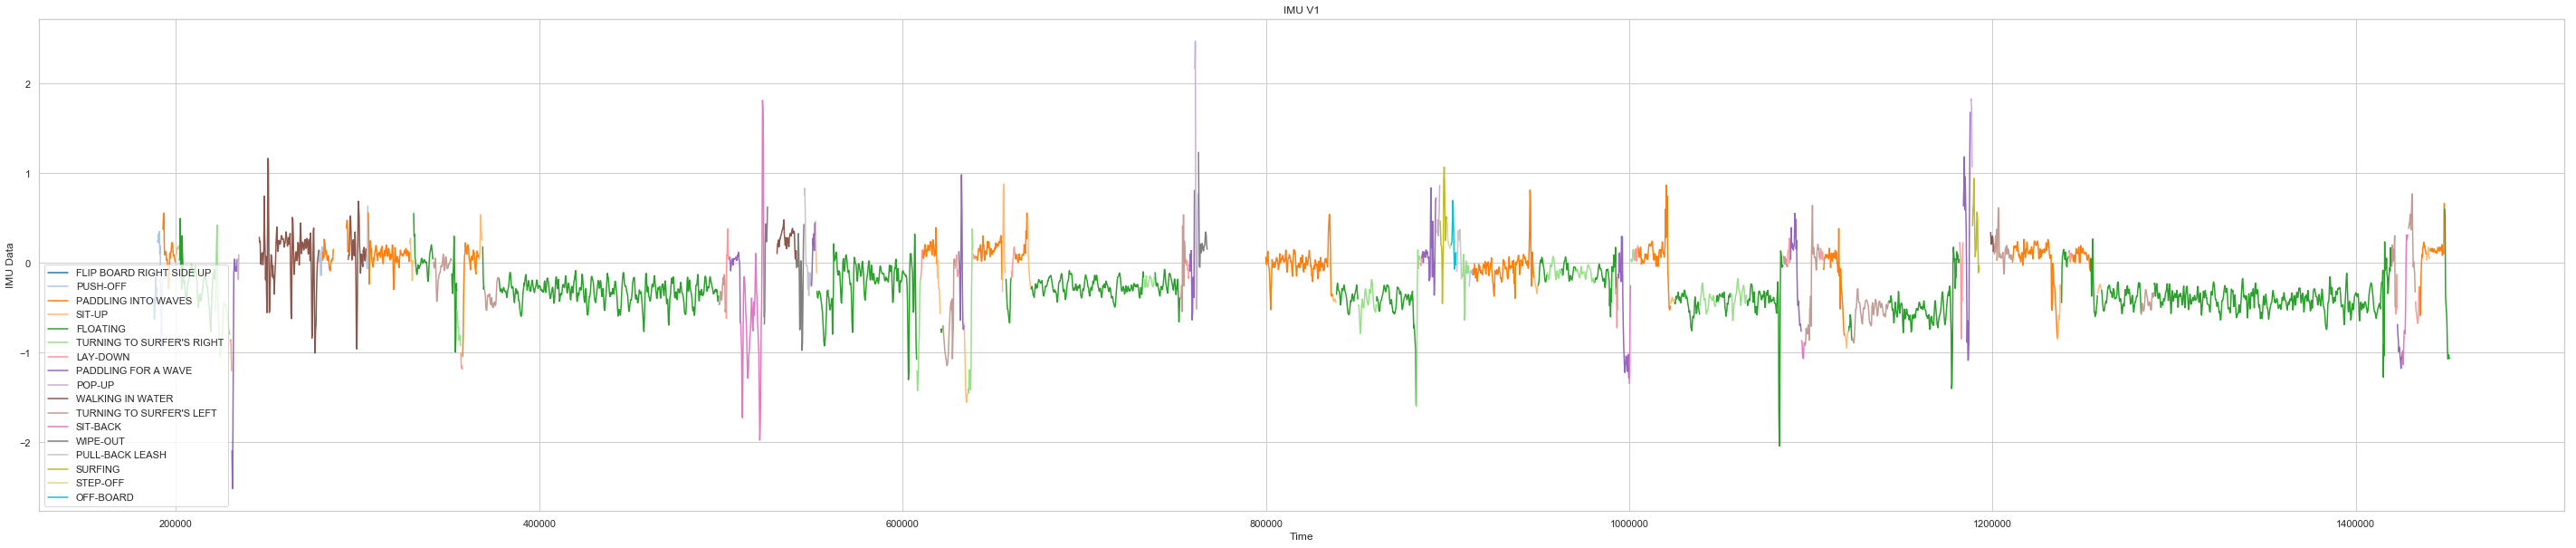

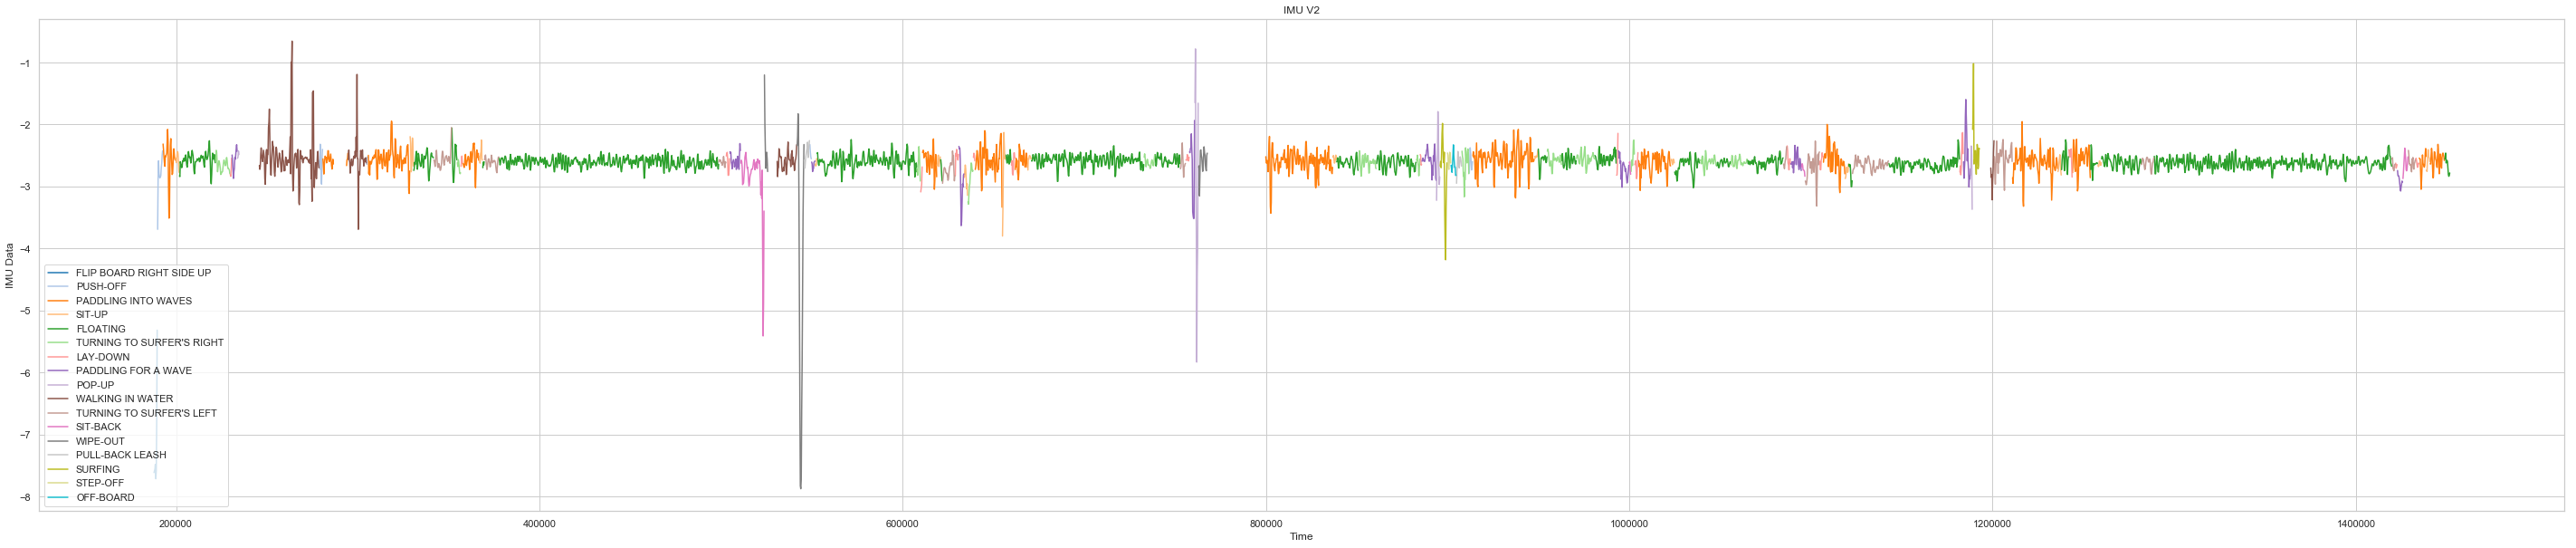

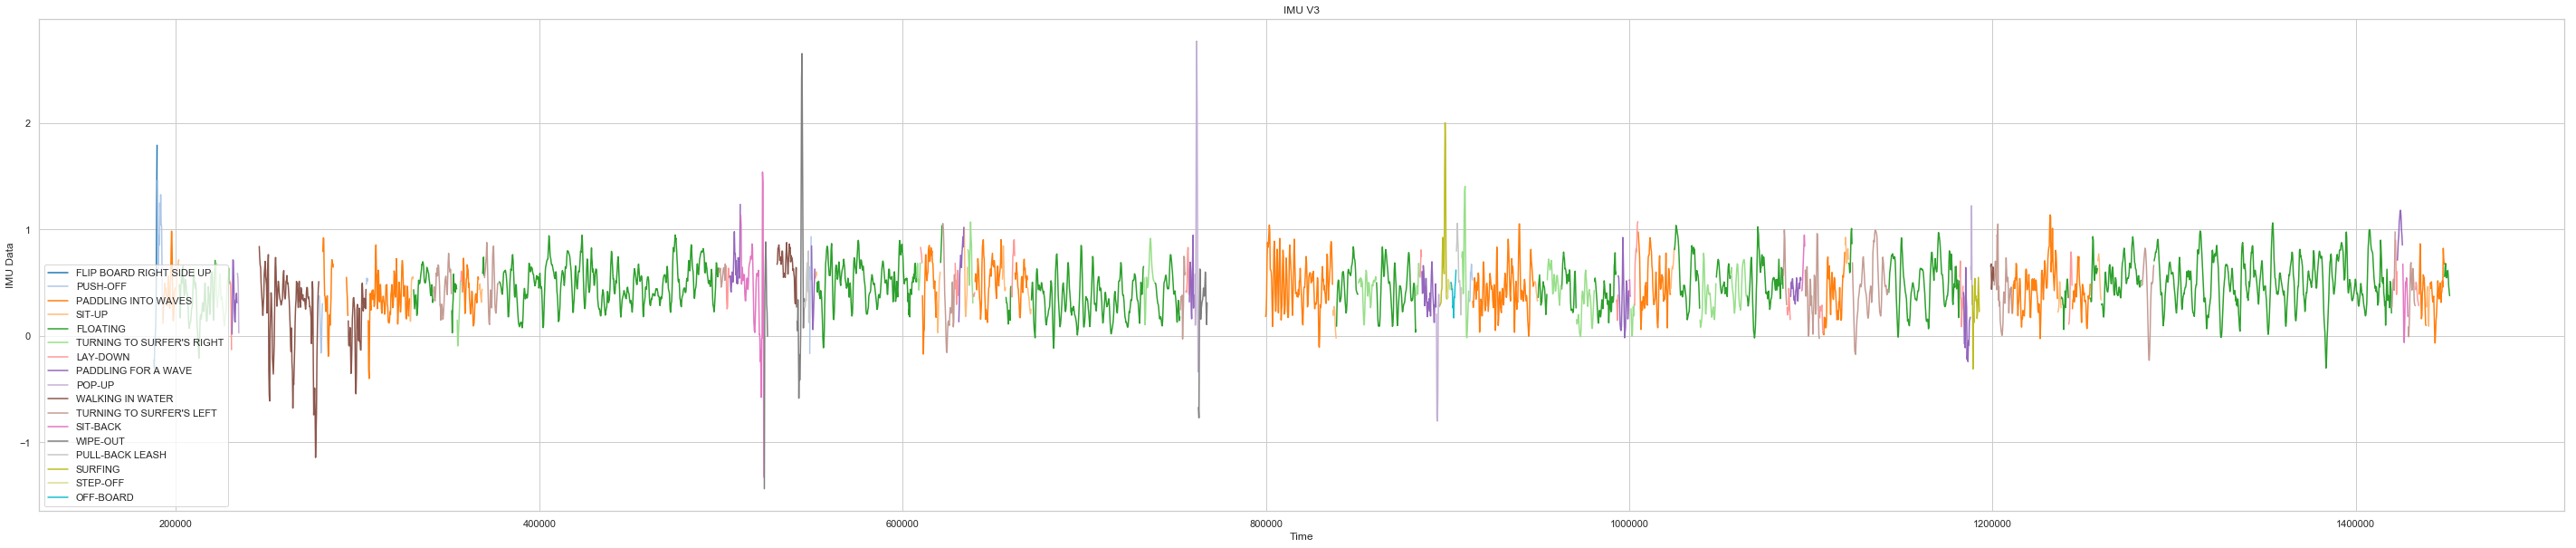

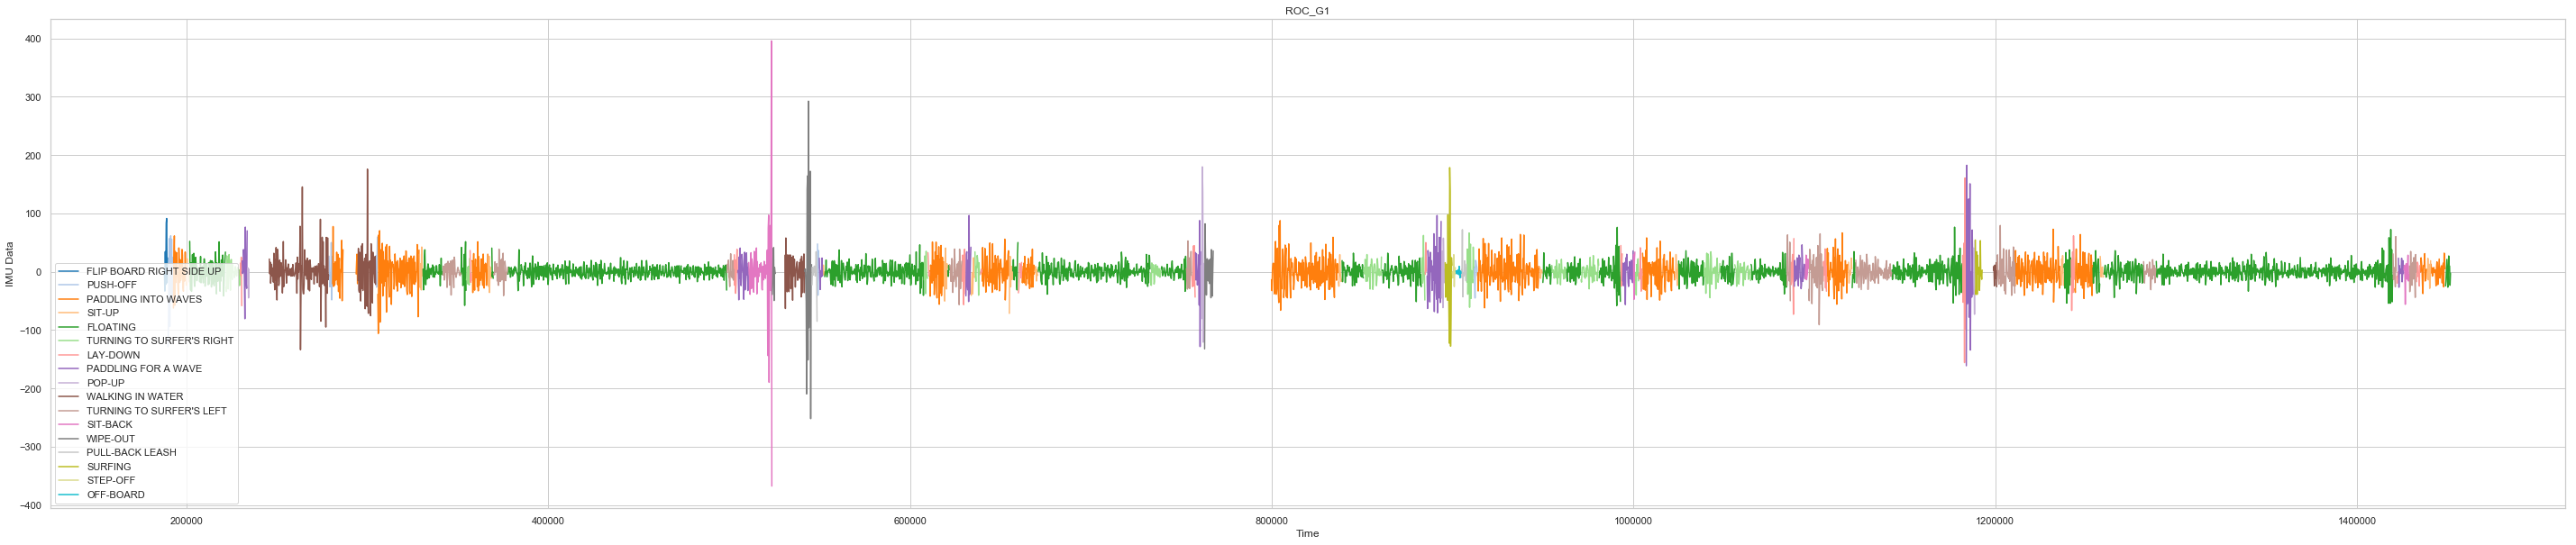

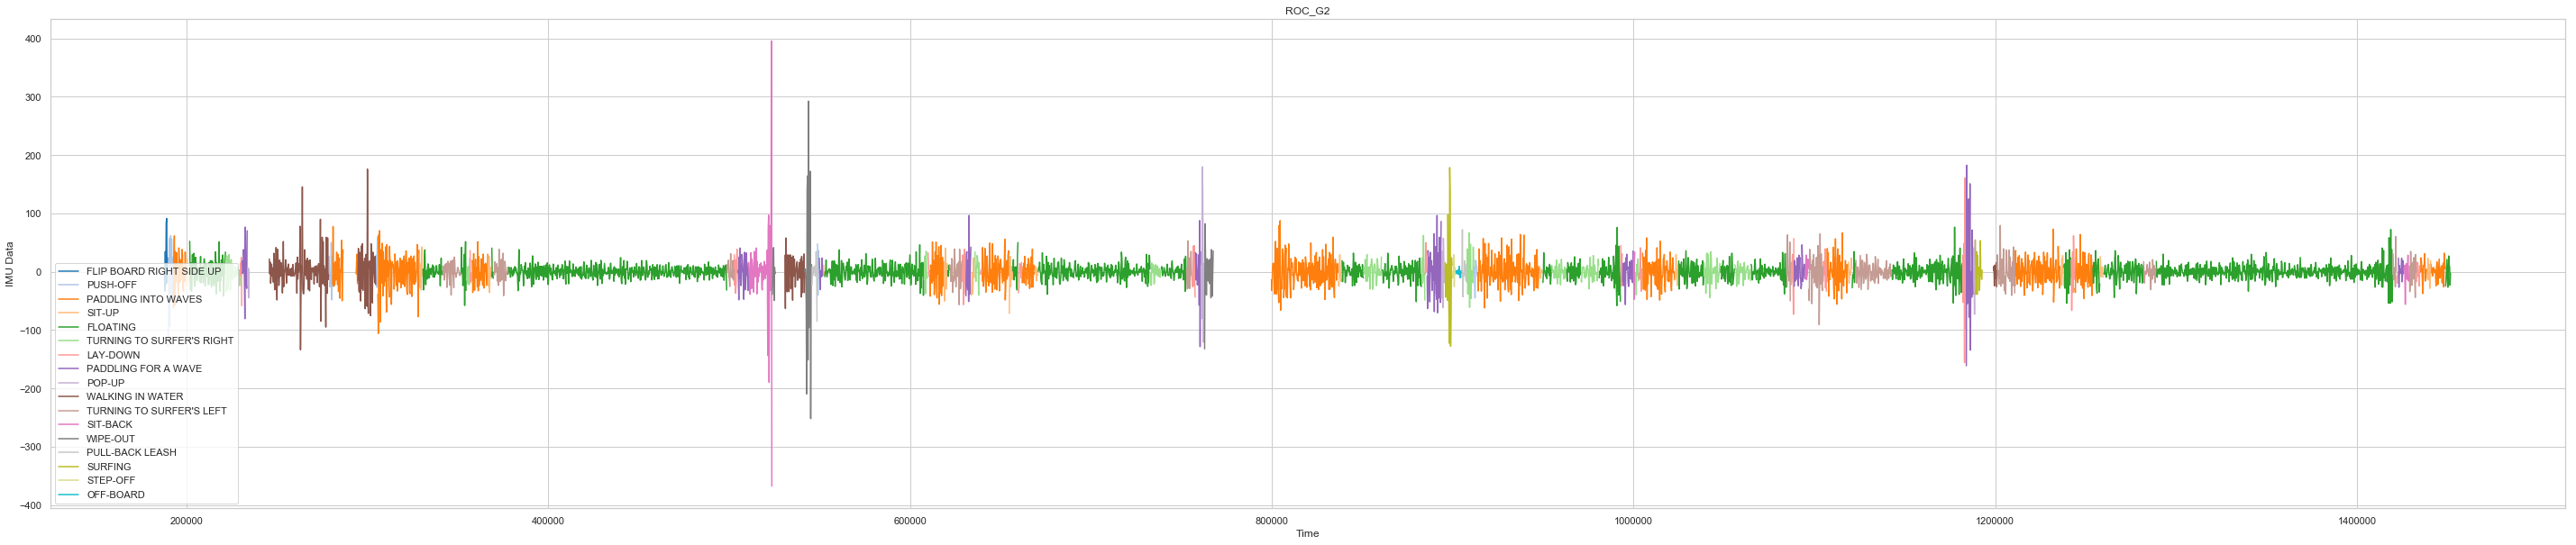

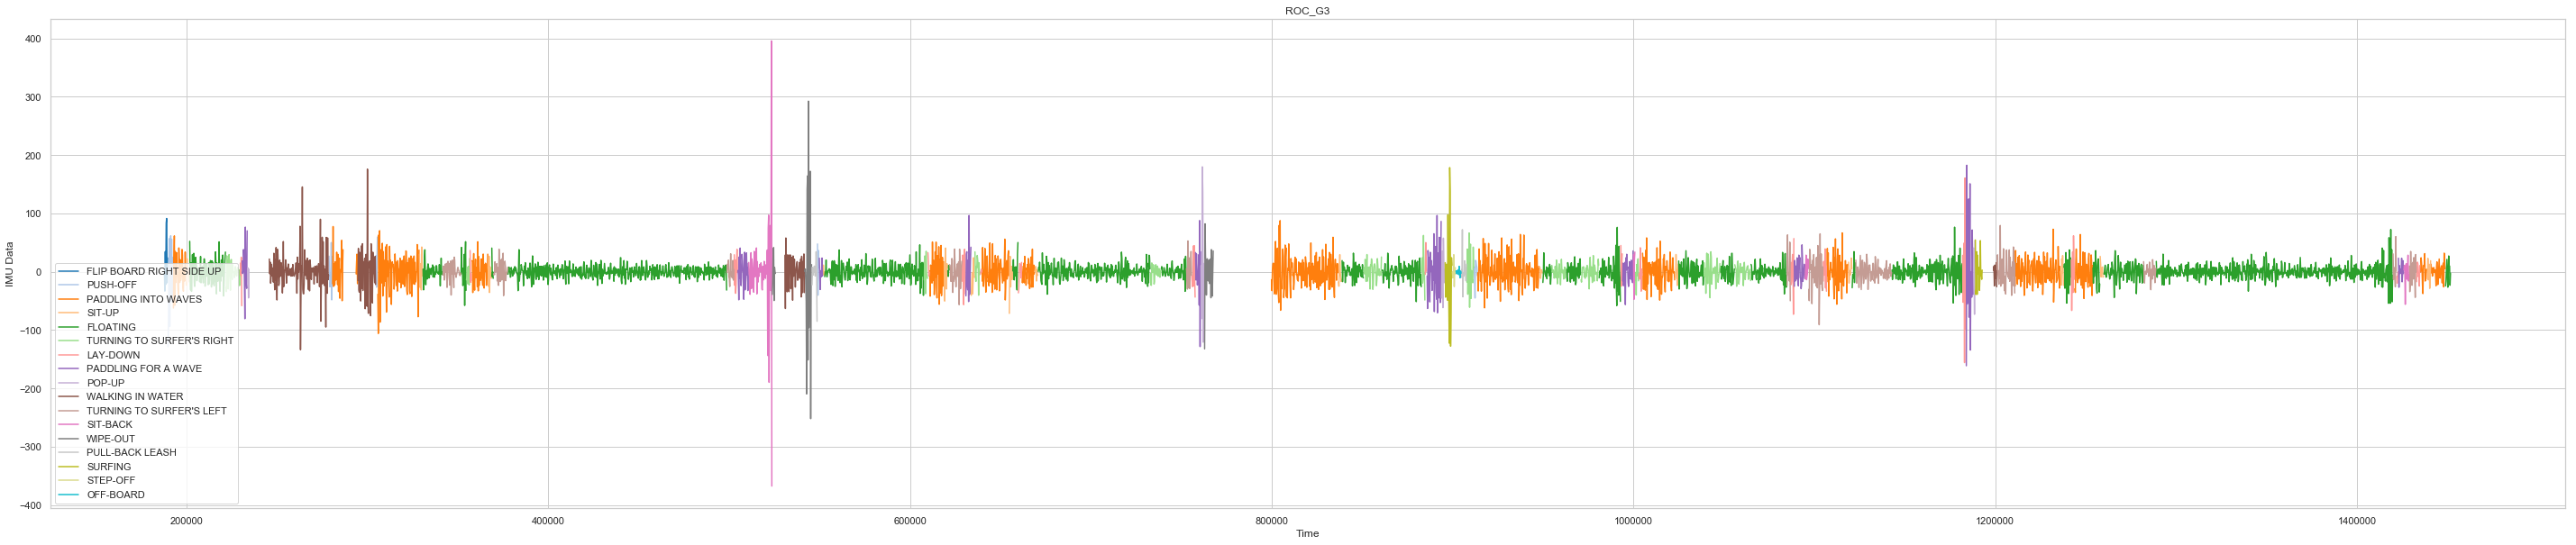

Done


In [364]:
#For plotting, just comment out the "concatenation" lines. 

#Need to clear kernel and then only run all above so that it plots on axes directly below, rather than on another plot
print("Creating Plots...")
createPlot(df3_complex,'IMU V1')
createPlot(df4_complex,'IMU V2')
createPlot(df3_complex,'IMU V3')
createPlot(df3_complex,'ROC_G1')
createPlot(df3_complex,'ROC_G2')
createPlot(df3_complex,'ROC_G3')


print("Done")

## Create complex labels from dataframe:

In [357]:
#Only keep the necessary input features:

#list(df_concatenated.iloc[:, 0:16])

multiclass_df = df_concatenated.drop(columns=["Time", "TimeDelta"])
multiclass_df = multiclass_df.iloc[:, 0:15]
list(multiclass_df)

['IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'IMU V1',
 'IMU V2',
 'IMU V3',
 'ROC_G1',
 'ROC_G2',
 'ROC_G3']

In [358]:
print("Creating multiclass dataframe...")

parse_df = df_concatenated.iloc[:, 17:]
print(list(parse_df))

#Parse the columns of the original dataframe to extract labels into a single column for the new multiclass df. 
def parse_func(x):
    l=[]
    val = 1
    for col in parse_df:
        if x[col] == val and col in accepted_labels:
            l.append(col)

    return pd.Series(l)

parse_df = parse_df.apply(parse_func, axis=1)
#print(parse_df.head(10))

#Concatenate the parse column with the multiclass dataframe. 
complex_multiclass_df = pd.concat([multiclass_df, parse_df], axis=1, sort=False)

#Rename labelled column: 
col_names = list(complex_multiclass_df)
col_names[-1] = "Complex_Label"
complex_multiclass_df.columns = col_names

print("\n Done creating complex multiclass df.")

complex_multiclass_df.head(10)


Creating multiclass dataframe...
['FLIP BOARD RIGHT SIDE UP', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S RIGHT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'POP-UP', 'WALKING IN WATER', "TURNING TO SURFER'S LEFT", 'SIT-BACK', 'WIPE-OUT', 'PULL-BACK LEASH', 'SURFING', 'STEP-OFF', 'OFF-BOARD']

 Done creating complex multiclass df.


IMU A1    IMU A2    IMU A3     IMU G1  \
ride_id UTC                                                                
15669   2018-11-07 20:30:35.850  0.114846 -2.861817 -2.048087 -44.634146   
        2018-11-07 20:30:36.114  1.626985  3.014470  1.320729  -3.658537   
        2018-11-07 20:30:36.345 -0.918768 -3.244637  1.722690  -5.731707   
        2018-11-07 20:30:36.609  2.641458  1.464049  1.071896  36.219512   
        2018-11-07 20:30:36.873  1.856677 -1.407101  0.248833 -32.073171   
        2018-11-07 20:30:37.104  2.411766 -5.579839  2.488330  10.365854   
        2018-11-07 20:30:37.368  6.909901 -6.556030  1.378152  20.365854   
        2018-11-07 20:30:37.632  3.809059 -2.134459  0.229692 -24.390244   
        2018-11-07 20:30:37.863  0.631653  0.487858  0.880486 -13.780488   
        2018-11-07 20:30:38.127  1.397293 -0.162936 -0.191410   9.512195   

                                    IMU G2     IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                     
15669   2018-11-07 20:30:35.850   1.219512   3.902439   -99.0  -167.0   207.0   
        2018-11-07 20:30:36.114 -17.073171   0.853659   -96.0  -168.0   176.0   
        2018-11-07 20:30:36.345 -10.243902  -9.512195   -91.0  -177.0   171.0   
        2018-11-07 20:30:36.609  -1.585366 -13.292683   -71.0  -165.0   177.0   
        2018-11-07 20:30:36.873   3.536585 -27.560976   -52.0  -156.0   204.0   
        2018-11-07 20:30:37.104  -0.853659 -15.121951   -29.0  -167.0   177.0   
        2018-11-07 20:30:37.368  -0.365854  15.731707   -24.0  -154.0   202.0   
        2018-11-07 20:30:37.632  -4.634146  35.000000   -51.0  -157.0   201.0   
        2018-11-07 20:30:37.863  11.829268  14.146341   -82.0  -170.0   194.0   
        2018-11-07 20:30:38.127   4.634146  10.243902   -89.0  -161.0   195.0   

                                   IMU V1    IMU V2    IMU V3     ROC_G1  \
ride_id UTC                                                                
15669   2018-11-07 20:30:35.850  0.014356 -1.607727 -0.256011   0.000000   
        2018-11-07 20:30:36.114  0.022331 -4.105511 -0.188220  40.975610   
        2018-11-07 20:30:36.345  0.068589 -2.757665  0.082944  -2.073171   
        2018-11-07 20:30:36.609  0.279140 -2.397177  0.342943  41.951220   
        2018-11-07 20:30:36.873  0.298281 -2.765641  0.253618 -68.292683   
        2018-11-07 20:30:37.104  0.575825 -2.960241  0.317422  42.439024   
        2018-11-07 20:30:37.368  0.931529 -3.628581  0.342943  10.000000   
        2018-11-07 20:30:37.632  1.094227 -3.689194  0.341348 -44.756098   
        2018-11-07 20:30:37.863  0.945884 -3.183553  0.207361  10.609756   
        2018-11-07 20:30:38.127  0.486500 -2.650795  0.076564  23.292683   

                                    ROC_G2     ROC_G3 Complex_Label  
ride_id UTC                                                          
15669   2018-11-07 20:30:35.850   0.000000   0.000000           NaN  
        2018-11-07 20:30:36.114  40.975610  40.975610           NaN  
        2018-11-07 20:30:36.345  -2.073171  -2.073171           NaN  
        2018-11-07 20:30:36.609  41.951220  41.951220           NaN  
        2018-11-07 20:30:36.873 -68.292683 -68.292683           NaN  
        2018-11-07 20:30:37.104  42.439024  42.439024           NaN  
        2018-11-07 20:30:37.368  10.000000  10.000000           NaN  
        2018-11-07 20:30:37.632 -44.756098 -44.756098           NaN  
        2018-11-07 20:30:37.863  10.609756  10.609756           NaN  
        2018-11-07 20:30:38.127  23.292683  23.292683           NaN

In [359]:
##Now perform ML models on concatenated files: 

## Training Multiclass Complex LR Model on Additional Input Features: 

In [360]:
#Print out distribution of data:
col_names = list(complex_multiclass_df)
labels = {'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', 'POP-UP', 'SURFING', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'STEP-OFF'}

#Try to drop NaN values:
complex_multiclass_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#Create a dictionary to store counts
data_distr = {}
total_count = 0.0

for label in labels:
    data_distr.update({label:0.0})

for name in complex_multiclass_df.iloc[:, -1]:
    if name in labels:
        total_count += 1.0
        count = data_distr[name]
        count = count + 1.0
        data_distr.update({name:count})
    
data_distr_p = {}
for label in labels:
    distr = data_distr[label]
    distr = distr/total_count
    data_distr_p.update({label:distr})
    print(label, "\t \t", data_distr[label], " --> \t", '%.4f' % data_distr_p[label], "%")


PUSH-OFF 	 	 288.0  --> 	 0.0072 %
LAY-DOWN 	 	 864.0  --> 	 0.0215 %
WALKING IN WATER 	 	 1792.0  --> 	 0.0446 %
PADDLING INTO WAVES 	 	 7168.0  --> 	 0.1785 %
TURNING TO SURFER'S LEFT 	 	 2720.0  --> 	 0.0677 %
WIPE-OUT 	 	 352.0  --> 	 0.0088 %
FLOATING 	 	 20928.0  --> 	 0.5211 %
TURNING TO SURFER'S RIGHT 	 	 2400.0  --> 	 0.0598 %
PADDLING FOR A WAVE 	 	 1408.0  --> 	 0.0351 %
PADDLING FOR POSITION 	 	 0.0  --> 	 0.0000 %
PULL-BACK LEASH 	 	 192.0  --> 	 0.0048 %
STEP-OFF 	 	 64.0  --> 	 0.0016 %
SIT-UP 	 	 928.0  --> 	 0.0231 %
POP-UP 	 	 192.0  --> 	 0.0048 %
SIT-BACK 	 	 608.0  --> 	 0.0151 %
SURFING 	 	 256.0  --> 	 0.0064 %


In [361]:
#Need to split into testing and training sets

#X = simple_multi_dataset.iloc[:, :-1].values  #selects everything until the last column listed
#y = simple_multi_dataset.iloc[:, -1].values   #selects the last column 

X = complex_multiclass_df.iloc[:, :-1].values  #selects everything until the last column listed
y = complex_multiclass_df.iloc[:, -1].values   #selects the last column 


print("X.shape:", X.shape)
print("y.shape:", y.shape)


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X.shape: (126208, 15)
y.shape: (126208,)
x_train shape: (113587, 15)
y_train shape: (113587,)
x_test shape: (12621, 15)
y_test shape: (12621,)


In [362]:
#Down-sample some classes:
floating_class = np.where(y == "FLOATING")[0]
paddling_into_class = np.where(y == "PADDLING INTO WAVES")[0]
turning_right_class = np.where(y == "TURNING TO SURFER'S RIGHT")[0]

#down_sample_classes = ["FLOATING", "PADDLING INTO WAVES", "TURNING TO SURFER'S RIGHT"]

other_class = np.where(y != ("FLOATING" or "PADDLING INTO WAVES" or "TURNING TO SURFER'S RIGHT"))[0]

floating_downsampled = np.random.choice(floating_class, size=1000, replace=False)
paddling_into_downsampled = np.random.choice(paddling_into_class, size=1000, replace=False)
turning_right_downsampled = np.random.choice(turning_right_class, size=1000, replace=False)

#y = np.hstack((y[other_class], y[floating_downsampled], y[paddling_into_downsampled], turning_right_downsampled))
lab = []
for yi in y: 
    if yi not in lab:
        lab.append(yi)
print(lab)
print(len(lab))

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [363]:
#Use SMOTE to balance out sets (but creates a LARGE dataset!)
from imblearn.over_sampling import SMOTE, ADASYN

X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))


TypeError: '<' not supported between instances of 'str' and 'float'

In [365]:
# Train multinomial logistic regression model using SMOTE
    
from sklearn import linear_model
from sklearn import metrics

mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train_res, y_train_res)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train_res, mul_lr.predict(X_train_res)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
    
    
# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)
#print(cm)        

/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Multinomial Logistic regression Train Accuracy ::  0.2307743855040609


ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [ ]:
%matplotlib inline

# import packages
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#axes.titlesize : 24
#axes.labelsize : 20
#lines.linewidth : 3
#lines.markersize : 10
#xtick.labelsize : 16
#ytick.labelsize : 16

class_names = ["FLOATING", "PADDLING", "SURFING"]

print("Plotting CM ...")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Multinomial LR normalized confusion matrix")
    else:
        print('Multinomial LR confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plot_confusion_matrix(cm, classes=class_names,
                      title='Multinomial LR confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Multinomial LR normalized confusion matrix')

plt.grid('off')

plt.show()


In [ ]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 10)
print(score)

print("Average score from confusion matrix:")
print(sum(score)/len(score))

## Train on "simple" dataset too (to compare results to previous experiments):

In [274]:
# Create "simple" dataset from "complex" dataset: 

print("Creating simple dataframe...")

#simple_multiclass_df = complex_multiclass_df.copy()
simple_multiclass_df = complex_multiclass_df

#print(complex_multiclass_df.head(10))
print("List:", list(complex_multiclass_df))

simple_labels = ["FLOATING", "PADDLING INTO WAVES", "PADDLING FOR A WAVE", "PADDLING FOR POSITION", "SURFING"]
simple_array = []


for name in complex_multiclass_df["Complex_Label"].values:
    #print(name)
    if name in simple_labels:
        if "PADDLING" in name: 
            name = "PADDLING"  
        simple_array.append(name)
    else:
        simple_array.append(0)
        
#print(simple_array)
    

simple_multiclass_df["Simple_Label"] = simple_array
simple_multiclass_df = simple_multiclass_df[simple_multiclass_df.Simple_Label != 0]

#simple_multiclass_df.loc[simple_multiclass_df['Complex_Label'].str.contains('PADDLING'), 'Complex_Label'] = 'PADDLING'
#simple_multiclass_df = simple_multiclass_df[simple_multiclass_df['Complex_Label'].str.match('FLOATING|PADDLING|SURFING')]

if "Complex_Label" in list(simple_multiclass_df):
    simple_multiclass_df = simple_multiclass_df.drop("Complex_Label", axis=1)



print("\n Done creating complex multiclass df.")

simple_multiclass_df.head(10)

Creating simple dataframe...
List: ['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'IMU V1', 'IMU V2', 'IMU V3', 'ROC_G1', 'ROC_G2', 'ROC_G3', 'Complex_Label', 'Simple_Label']

 Done creating complex multiclass df.


IMU A1    IMU A2    IMU A3    IMU G1  \
ride_id UTC                                                               
15629   2018-10-31 19:59:02.739 -0.899627  0.066756  0.861345  5.121951   
        2018-10-31 19:59:02.937 -0.918768  0.066756  0.746499  7.073171   
        2018-10-31 19:59:03.135 -1.052755 -0.373487  0.842204 -5.121951   
        2018-10-31 19:59:03.333 -1.129319 -0.985999  0.880486 -9.024390   
        2018-10-31 19:59:03.564 -1.225024 -0.641461  1.186742 -5.975610   
        2018-10-31 19:59:03.762 -0.899627 -0.430910  1.339870 -8.292683   
        2018-10-31 19:59:03.960 -0.612512 -0.450051  1.205883 -0.609756   
        2018-10-31 19:59:04.158 -0.708217 -0.526615  0.861345  6.097561   
        2018-10-31 19:59:04.356 -0.746499 -0.545756  0.727358  9.512195   
        2018-10-31 19:59:04.554 -0.976191 -0.450051  0.650794  9.634146   

                                   IMU G2    IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                   
15629   2018-10-31 19:59:02.739  2.682927  6.829268   -11.0  -155.0   -17.0   
        2018-10-31 19:59:02.937  1.463415 -0.853659   -17.0  -161.0    -1.0   
        2018-10-31 19:59:03.135 -0.121951 -7.439024    -6.0  -154.0    -8.0   
        2018-10-31 19:59:03.333 -0.365854 -4.146341    -4.0  -148.0    -8.0   
        2018-10-31 19:59:03.564 -1.951220  3.780488    -4.0  -154.0   -28.0   
        2018-10-31 19:59:03.762 -2.317073  7.804878    -7.0  -151.0   -33.0   
        2018-10-31 19:59:03.960 -1.341463  5.487805   -17.0  -141.0   -41.0   
        2018-10-31 19:59:04.158 -0.487805 -0.487805   -21.0  -149.0   -41.0   
        2018-10-31 19:59:04.356 -3.658537 -3.658537   -26.0  -152.0   -34.0   
        2018-10-31 19:59:04.554 -3.902439  0.000000   -20.0  -146.0   -34.0   

                                   IMU V1    IMU V2    IMU V3     ROC_G1  \
ride_id UTC                                                                
15629   2018-10-31 19:59:02.739 -0.271164 -2.567850  0.208956   5.609756   
        2018-10-31 19:59:02.937 -0.245643 -2.519998  0.202576   1.951220   
        2018-10-31 19:59:03.135 -0.239262 -2.519998  0.204171 -12.195122   
        2018-10-31 19:59:03.333 -0.258404 -2.607728  0.205766  -3.902439   
        2018-10-31 19:59:03.564 -0.283925 -2.666746  0.242453   3.048780   
        2018-10-31 19:59:03.762 -0.271164 -2.671531  0.283925  -2.317073   
        2018-10-31 19:59:03.960 -0.228097 -2.626869  0.311041   7.682927   
        2018-10-31 19:59:04.158 -0.185030 -2.617298  0.283925   6.707317   
        2018-10-31 19:59:04.356 -0.172269 -2.626869  0.232882   3.414634   
        2018-10-31 19:59:04.554 -0.202576 -2.626869  0.186625   0.121951   

                                    ROC_G2     ROC_G3 Simple_Label  
ride_id UTC                                                         
15629   2018-10-31 19:59:02.739   5.609756   5.609756     FLOATING  
        2018-10-31 19:59:02.937   1.951220   1.951220     FLOATING  
        2018-10-31 19:59:03.135 -12.195122 -12.195122     FLOATING  
        2018-10-31 19:59:03.333  -3.902439  -3.902439     FLOATING  
        2018-10-31 19:59:03.564   3.048780   3.048780     FLOATING  
        2018-10-31 19:59:03.762  -2.317073  -2.317073     FLOATING  
        2018-10-31 19:59:03.960   7.682927   7.682927     FLOATING  
        2018-10-31 19:59:04.158   6.707317   6.707317     FLOATING  
        2018-10-31 19:59:04.356   3.414634   3.414634     FLOATING  
        2018-10-31 19:59:04.554   0.121951   0.121951     FLOATING

In [ ]:
#Need to split into testing and training sets

X = simple_multiclass_df.iloc[:, :-1].values  #selects everything until the last column listed
y = simple_multiclass_df.iloc[:, -1].values   #selects the last column 


print("X.shape:", X.shape)
print("y.shape:", y.shape)


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
#Use SMOTE to balance out sets (but creates a LARGE dataset!)
from imblearn.over_sampling import SMOTE, ADASYN

X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)
    
# Train multinomial logistic regression model using SMOTE
    
from sklearn import linear_model
from sklearn import metrics

mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train_res, y_train_res)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train_res, mul_lr.predict(X_train_res)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
    
    
# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)
print(cm)        

In [ ]:
%matplotlib inline

# import packages
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#axes.titlesize : 24
#axes.labelsize : 20
#lines.linewidth : 3
#lines.markersize : 10
#xtick.labelsize : 16
#ytick.labelsize : 16

class_names = ["FLOATING", "PADDLING", "SURFING"]

print("Plotting CM ...")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Multinomial LR normalized confusion matrix")
    else:
        print('Multinomial LR confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plot_confusion_matrix(cm, classes=class_names,
                      title='Multinomial LR confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Multinomial LR normalized confusion matrix')

plt.grid('off')

plt.show()


In [ ]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 10)
print(score)

print("Average score from confusion matrix:")
print(sum(score)/len(score))